Import Helper Functions and Libraries

In [ ]:
%pylab inline
from lib.setup import *
from lib.editing import *
from lib.fileinfo import *
from lib.conversion import *
from lib.running import *
from lib.results import *
from lib.graphing import *

For testing: 

Use full_word_test(drs, p_range) to generate a results dict for each dr and word within

Use full_input_test(drs, p_range) to generate results by dr for each individual input

Use cut_test(drs, p_range) to get results in the form input-based, word-based, word bank

In [13]:
drs = [i for i in range(1, 9)]
#res, wb = full_input_test(drs, 5)
#res, wb = adj_input_test(drs, 5, 8000, 24000)
#test, wb = full_word_test(drs, 5)
inputs, words, wb = cut_test(drs, 5)
dis = ['New England', 'Northern', 'North Midland', 'South Midland', 'Southern', 'NYC', 'Western', 'Army Brat']

Overall Dialect Score Tests

In [23]:
#tests total accuracy of each dr, uses input test, n is success threshold
def dr_input_acc(res, n):
    s = []
    for i in range(len(res)):
        scores = 0
        total = 0
        dr = res[i]
        for pair in dr:
            #print(pair)
            scores += arr_top_n(pair[0], pair[1], n)
            #scores += adj_top_n(pair[0], pair[1], n)
            total += 1
        #print(f"Score: {scores}, total: {total}")
        s.append(scores/total)
    graph_bar(s, dis, "Input Accuracy by DR", "Success Rate", f"dr-input-acc(cut)-{n}")

#uses full_word_test
def dr_word_acc(res, n):
    s = []
    for i in range(len(res)):
        scores = 0
        total = 0
        dr = res[i]
        for key in dr:
            #print(key, dr[key])
            scores += check_top_n(key, dr[key], n)
            total += 1
        #print(total)
        s.append(scores/total)
    graph_bar(s, dis, "Word Accuracy by DR", "Success Rate", f"dr-word-acc(cut)-{n}")


Score for dr 1: 0.3860232945091514.
Score for dr 2: 0.4180522565320665.
Score for dr 3: 0.42065868263473055.
Score for dr 4: 0.4335719968178202.
Score for dr 5: 0.42411812961443807.
Score for dr 6: 0.4318181818181818.
Score for dr 7: 0.4374508261211644.
Score for dr 8: 0.4715261958997722.


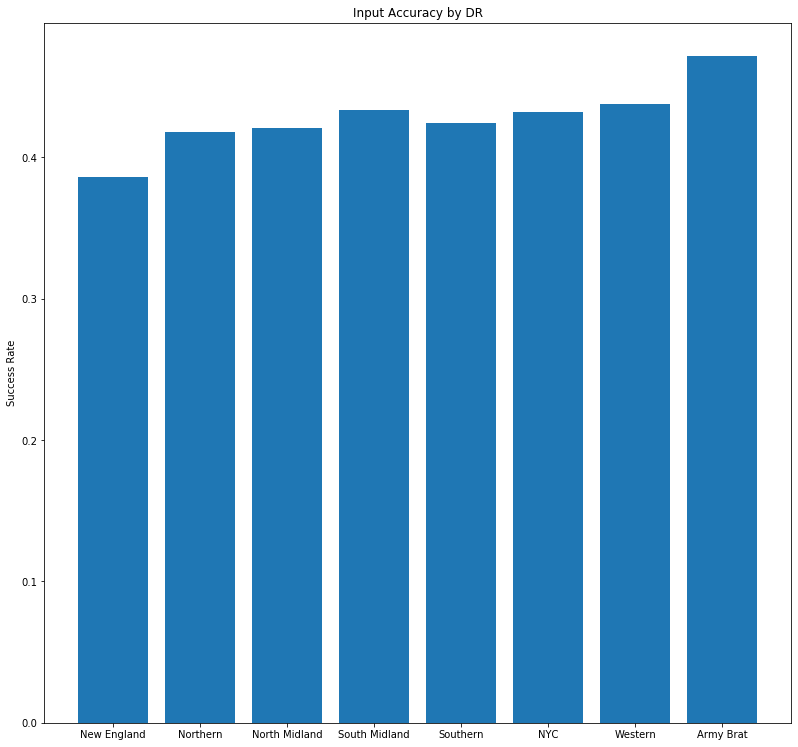

Score for dr 1: 0.3492822966507177.
Score for dr 2: 0.34328358208955223.
Score for dr 3: 0.31086142322097376.
Score for dr 4: 0.3359683794466403.
Score for dr 5: 0.312280701754386.
Score for dr 6: 0.3969849246231156.
Score for dr 7: 0.32971014492753625.
Score for dr 8: 0.4117647058823529.


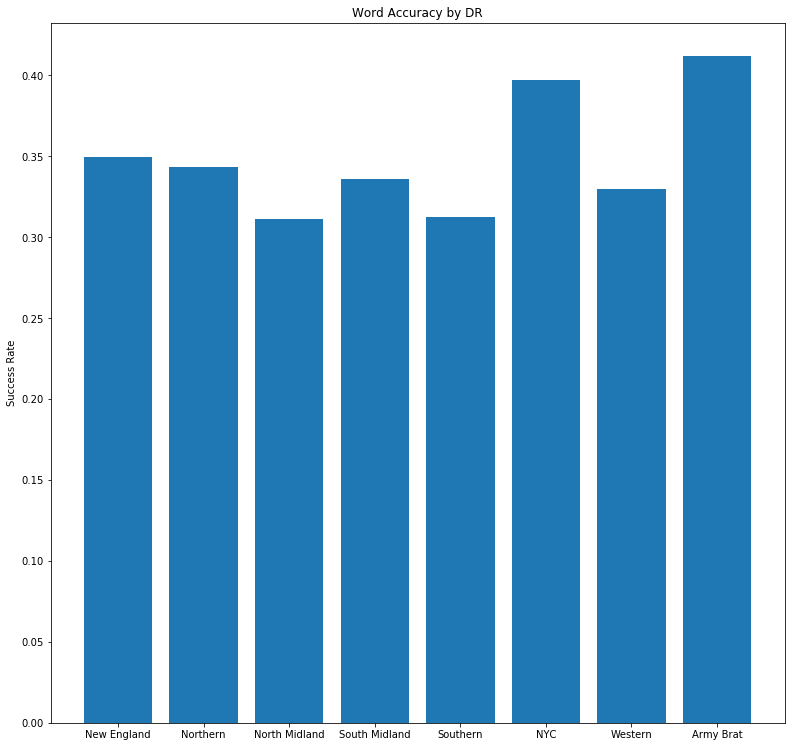

In [15]:
dr_input_acc(inputs, 5)
dr_word_acc(words, 5)

Dialect Matrices

In [16]:
#generates a heatmap for each dialect (should show as diagonal) - uses word input
def di_matrices(res, wb):
    for dr in range(len(res)):
        results = res[dr - 1]
        words = set()

        for keys in results:
            words.add(keys)
        y_adds = set()
        for keys in results:
            for key in results[keys]:
                if key not in words:
                    y_adds.add(key)
        xlabels = sorted(list(words), key = lambda x: wb[x])
        y_adds = sorted(list(y_adds), key = lambda x: wb[x])
        ylabels = xlabels + y_adds

        m = len(ylabels)
        n = len(xlabels)

        data = np.zeros((m, n))

        for key in results:
            sd = results[key]
            xpos = xlabels.index(key)
            s = 0
            for key in sd:
                s += sd[key]
            for key in sd:
                ypos = ylabels.index(key)
                data[ypos][xpos] = sd[key] / s

        for i in range(len(xlabels)):
            xlabels[i] = wb[xlabels[i]]

        graph_matrix(data, False, f"Heatmap for DR{dr + 1}", f"Heatmap-DR{dr + 1}")

Zero and Poor Word Performance Testing

In [17]:
#finds which words were not in the top n predictions for themselves across multiple dialects
def cross_failure(res, n, wb):
    failures = dict()
    output = []
    for dr in res:
        for word in dr:
            if not check_top_n(word, dr[word], n):
                if word in failures:
                    failures[word] += 1
                else:
                    failures[word] = 1
    for word in failures:
        if failures[word] >= 3:
            output.append((wb[word], failures[word]))
    return sorted(output, key = lambda x : x[1])[::-1]

Input Size Correlation

In [18]:
def input_count():
    res = []
    for dr in range(1, 9):
        dr_path = os.path.join(f"cuts", f"DR{dr}")
        drc = 0

        for sd in os.listdir(dr_path):
            base_path = os.path.join(dr_path, sd)
            if os.path.isdir(base_path):
                    #print(f"Entering subdirectory number {sdc}; {sd}.")
                for f in os.listdir(base_path):
                    drc += 1
        res.append(drc)
    graph_bar(res, dis, "Input Size by DR", "Amount of Inputs", "input-sizes")

Common Misclassifications

In [19]:
#finds shared misses when target word isn't in top n (uses words)
def common_miss(res, n, wb):
    mispreds = dict()
    for dr in range(len(res)):
        dic = res[dr]
        for key in dic:
            subdic = dic[key]
            if not check_top_n(key, subdic, n):
                misclass = find_max_word(subdic)
                if key in mispreds:
                    mispreds[key] += 1
                else:
                    mispreds[key] = 1
    #check for multiples
    ret = []
    for key in mispreds:
        if mispreds[key] >= 2:
            ret.append((wb[key], mispreds[key]))
    return sorted(ret, key = lambda x: x[1])[::-1]

Length Testing

In [20]:
#helper function
def incr_res(dic, key, truth):
    if key in dic:
        dic[key][1] += 1
        if truth:
            dic[key][0] += 1
    else:
        dic[key] = [0, 1]
        if truth:
            dic[key][0] = 1
    return dic

#measures length of target vs length of result, uses input test
def test_lengths(res, wb, n):
    letters = dict()
    sylls = dict()
    for dr in range(len(res)):
        dic = res[dr]
        for sub in dic:
            key = sub[0]
            word = wb[key]
            arr = sub[1]
            let = len(word)
            syl = p.Word(word).numSyll
            flag = arr_top_n(key, arr, n)
            letters = incr_res(letters, let, flag)
            sylls = incr_res(sylls, syl, flag)
    
    l = len(letters)
    heights = []
    x_labels = sorted(letters)
    for label in x_labels:
        heights.append(letters[label][0] / letters[label][1])
    graph_bar(heights, x_labels, "Model Success by Length (in letters)", "Success Rate", "length-rate(let)")

    l = len(sylls)
    heights = []
    x = [i for i in range(l)]
    x_labels = sorted(sylls)
    for label in x_labels:
        heights.append(sylls[label][0] / sylls[label][1])
    graph_bar(heights, x_labels, "Model Success by Length (in syllables)", "Success Rate", "length-rate(syl)")

#helper
def incr_lens(dic, key, val):
    if key in dic:
        dic[key][1] += 1
        dic[key][0] += val
    else:
        dic[key] = [val, 1]
    return dic

#measures average failure length, again uses input test
def av_fail_len(res, wb):
    letters = dict()
    sylls = dict()
    for dr in range(len(res)):
        dic = res[dr]
        for sub in dic:
            key = sub[0]
            word = wb[key]
            arr = sub[1]
            let = len(word)
            syl = p.Word(word).numSyll
            output = arr_max(arr)
            if output != key:
                output = wb[output]
                out_let = len(output)
                out_syl = p.Word(output).numSyll
                letters = incr_lens(letters, let, out_let)
                sylls = incr_lens(sylls, syl, out_syl)
    heights = []
    x_labels = sorted(letters)
    for label in x_labels:
        heights.append(letters[label][0] / letters[label][1])
    graph_bar(heights, x_labels, f"Average Length of Failed Predictions (by number of letters)", "Average Failure Length", "fail_len(let)")

    heights = []
    x_labels = sorted(sylls)
    for label in x_labels:
        heights.append(sylls[label][0] / sylls[label][1])
    graph_bar(heights, x_labels, f"Average Length of Failed Predictions (by number of syllables)", "Average Failure Length", "fail_len(syl)")

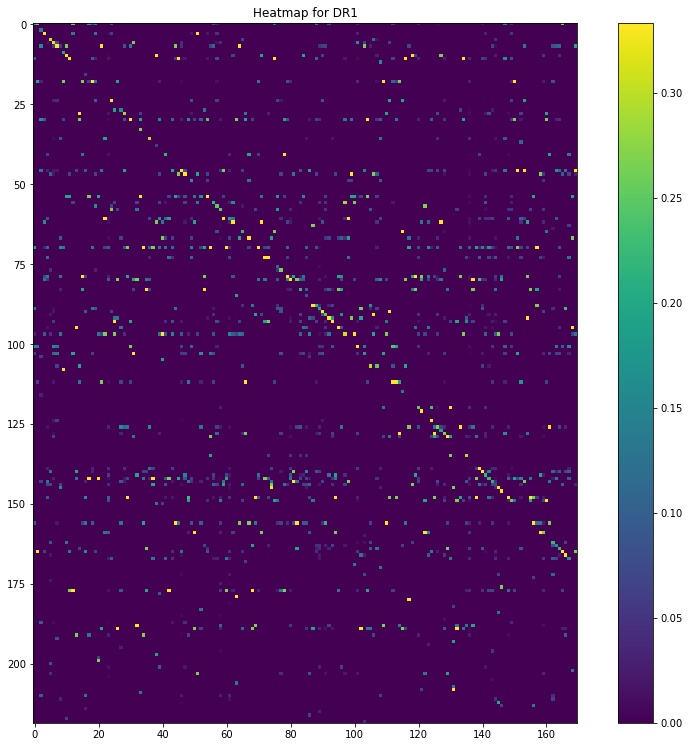

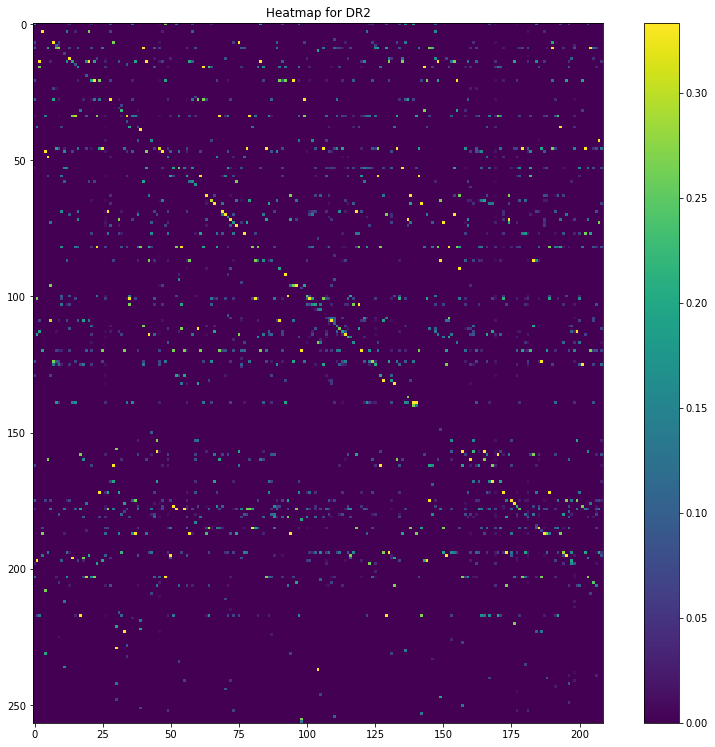

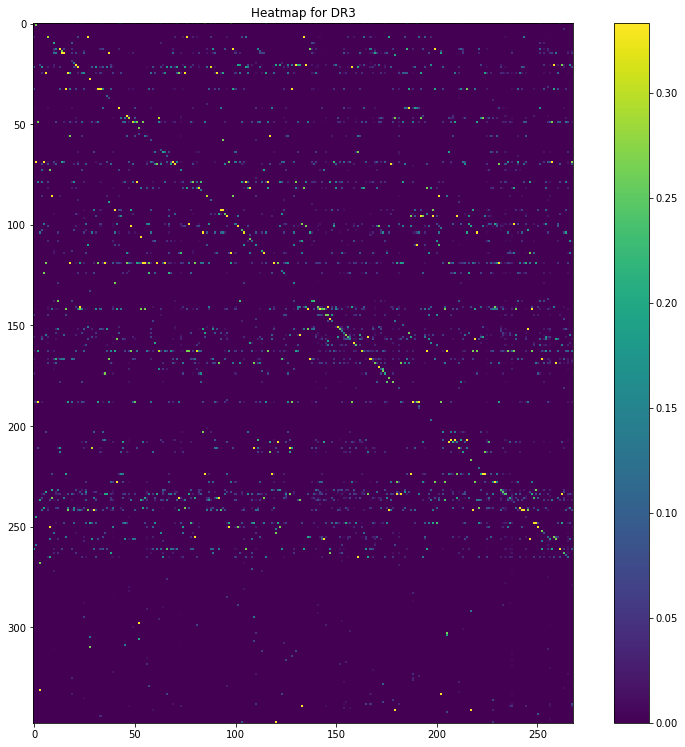

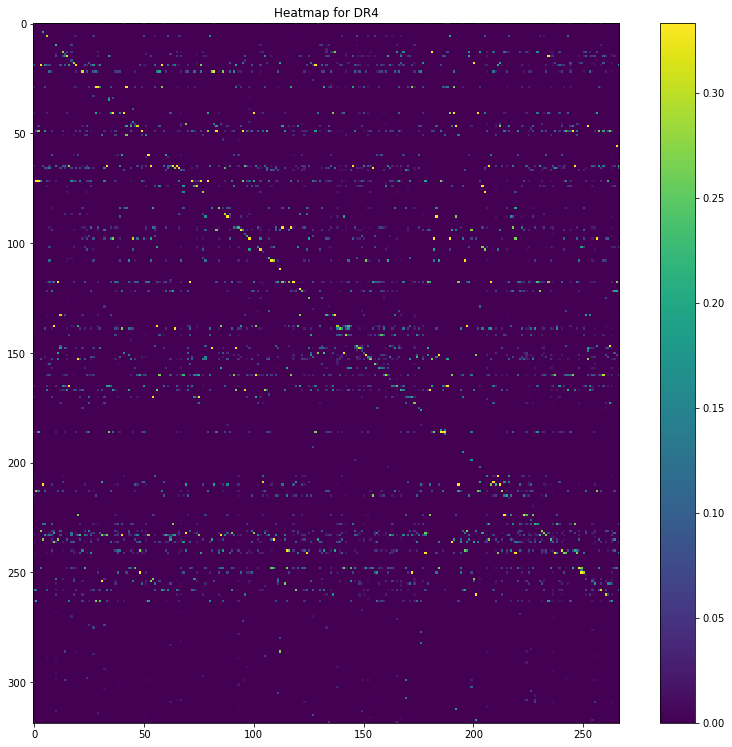

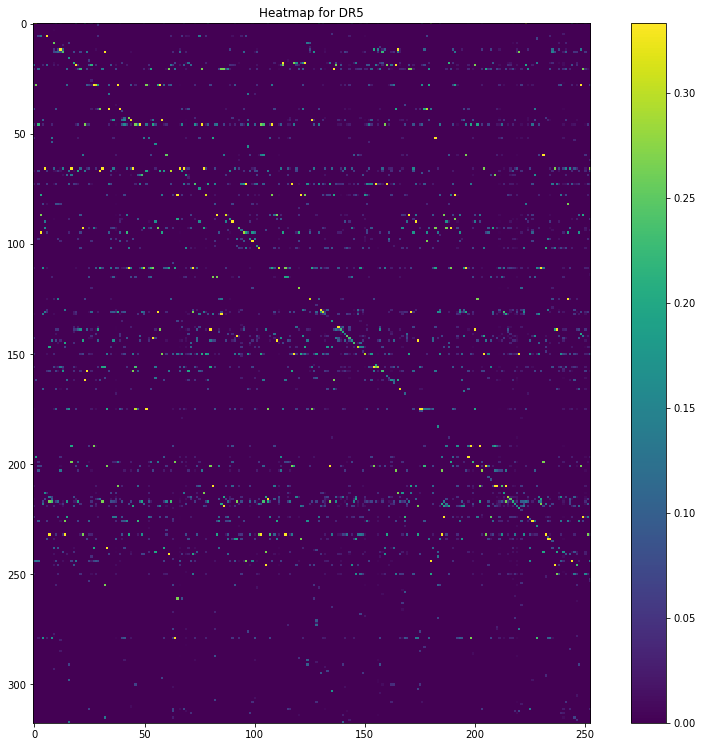

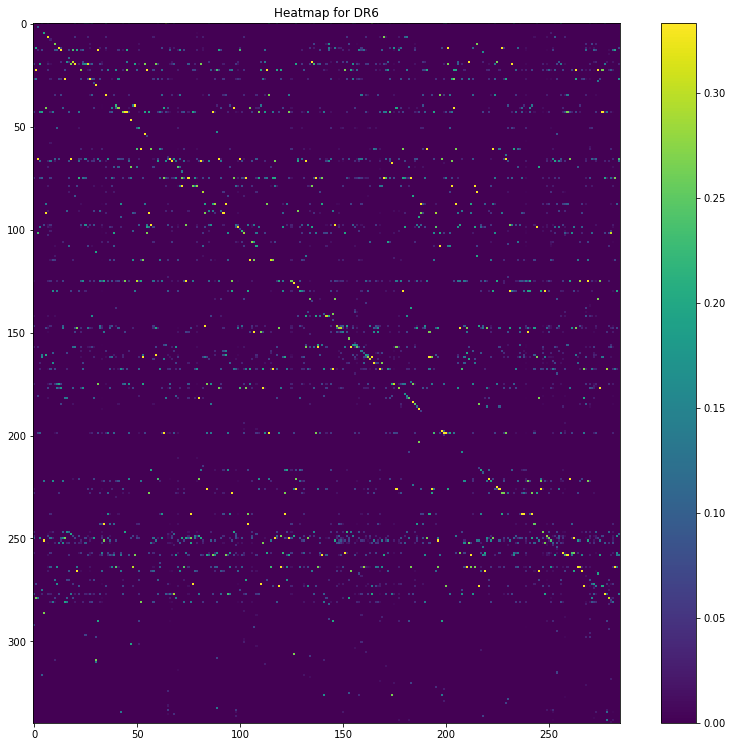

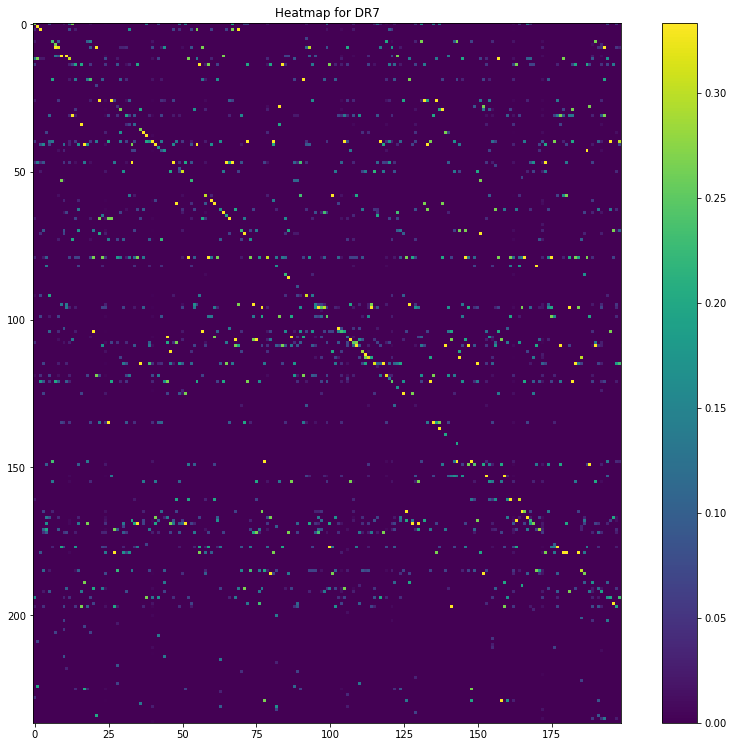

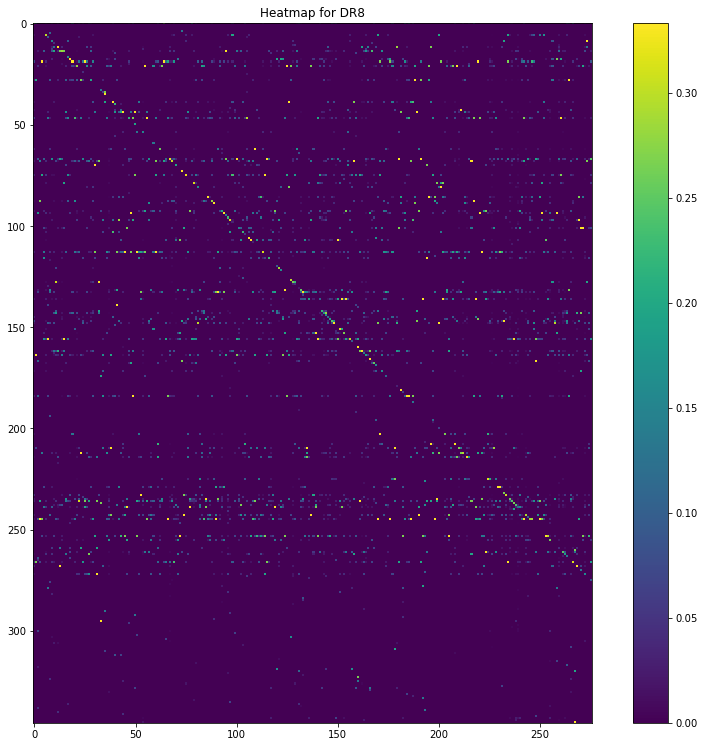

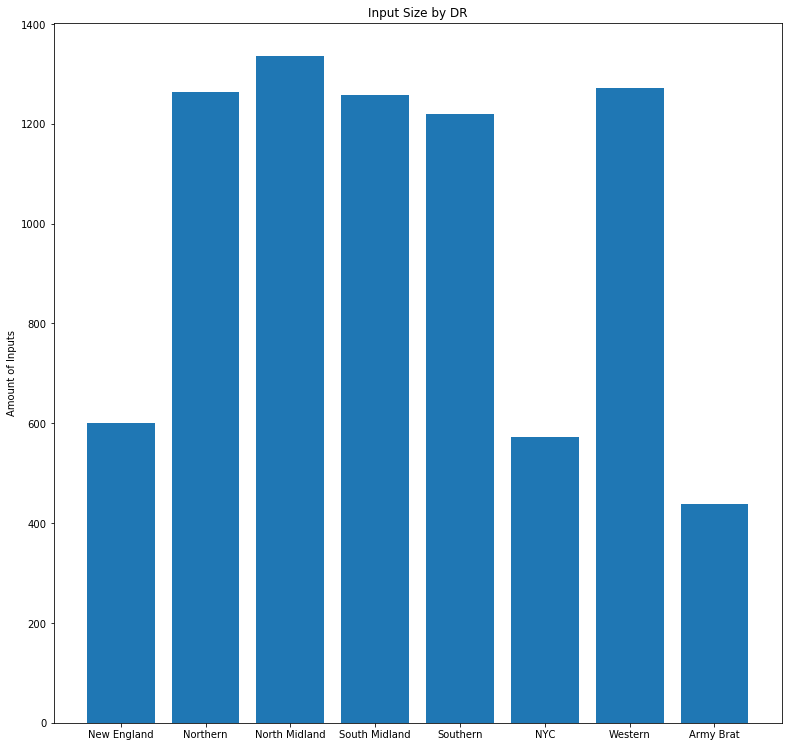

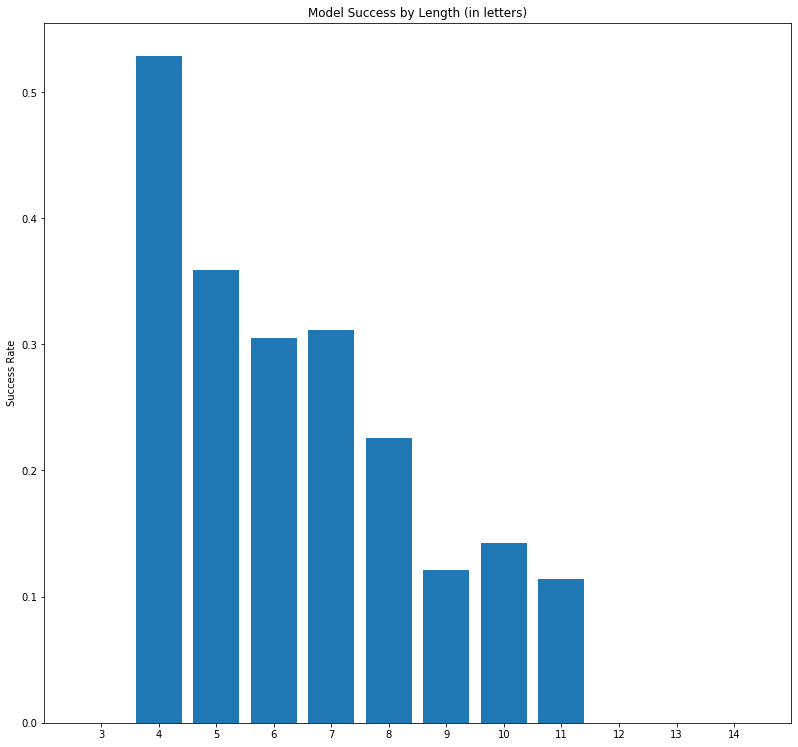

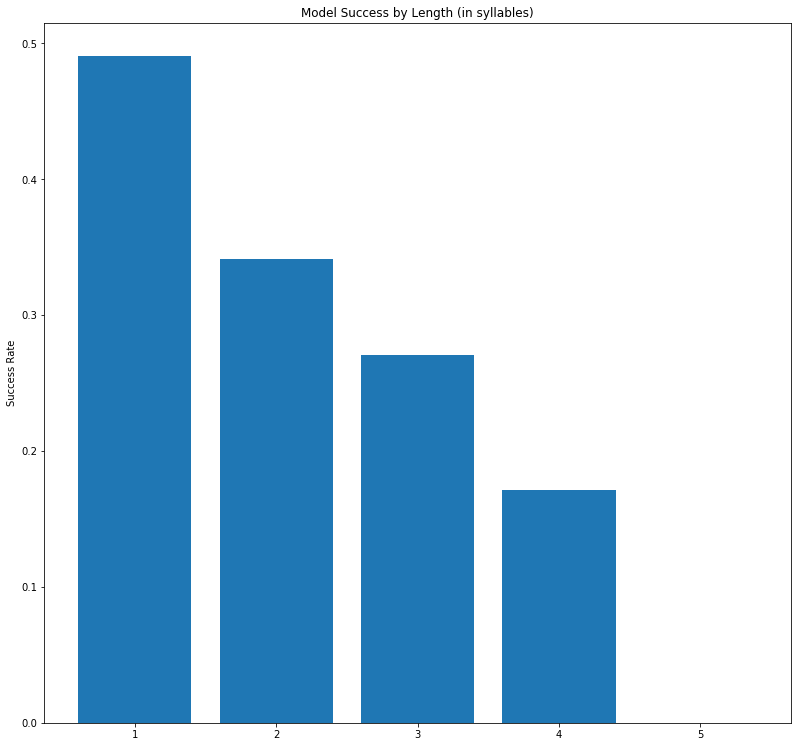

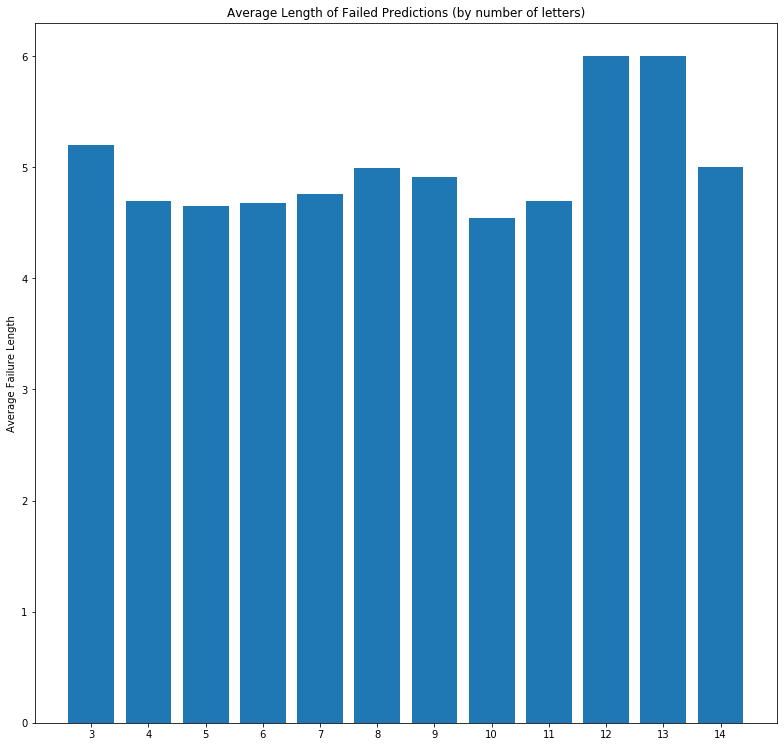

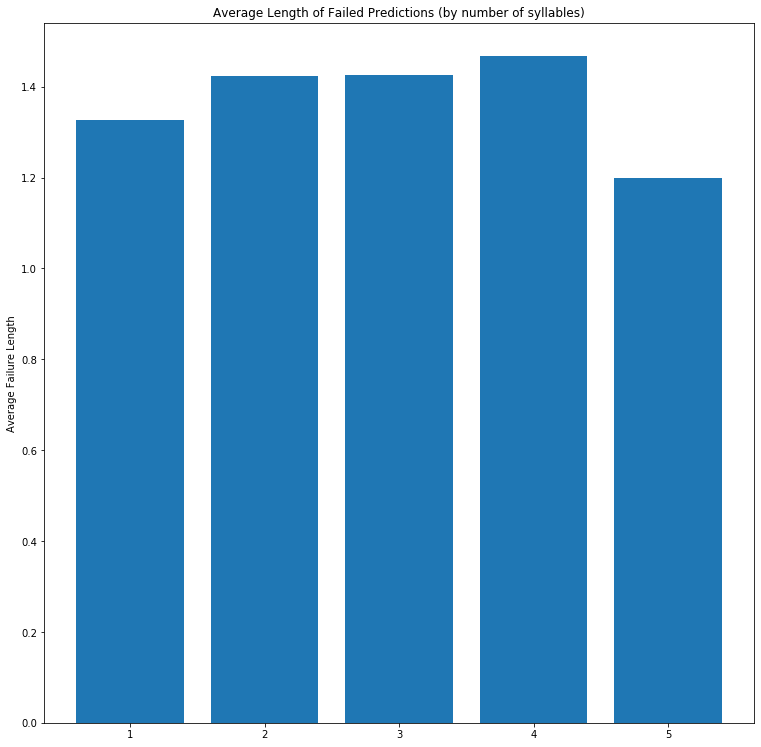

In [21]:
di_matrices(words, wb)
input_count()
test_lengths(inputs, wb, 3)
av_fail_len(inputs, wb)

In [22]:
cross_failure(words, 3, wb)
common_miss(words, 3, wb)

[('bought', 8),
 ('young', 8),
 ('agency', 8),
 ('place', 8),
 ('early', 8),
 ('system', 8),
 ('does', 8),
 ('took', 8),
 ('monday', 8),
 ('thought', 8),
 ('came', 8),
 ('suit', 8),
 ('carry', 8),
 ('become', 8),
 ('life', 7),
 ('couldnt', 7),
 ('process', 7),
 ('call', 7),
 ('store', 7),
 ('ever', 7),
 ('results', 7),
 ('income', 7),
 ('data', 7),
 ('needed', 7),
 ('best', 7),
 ('began', 7),
 ('keep', 7),
 ('nothing', 7),
 ('times', 7),
 ('clear', 7),
 ('mean', 7),
 ('needs', 7),
 ('home', 7),
 ('women', 7),
 ('common', 7),
 ('night', 7),
 ('same', 7),
 ('look', 7),
 ('number', 7),
 ('again', 7),
 ('related', 7),
 ('true', 7),
 ('open', 7),
 ('within', 7),
 ('social', 7),
 ('people', 6),
 ('head', 6),
 ('either', 6),
 ('instead', 6),
 ('face', 6),
 ('changes', 6),
 ('study', 6),
 ('longer', 6),
 ('book', 6),
 ('black', 6),
 ('done', 6),
 ('start', 6),
 ('years', 6),
 ('theyre', 6),
 ('makes', 6),
 ('sure', 6),
 ('things', 6),
 ('plant', 6),
 ('subject', 6),
 ('action', 6),
 ('left', 6